# Bloco 1: Importações (Focadas em Regressão)

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Importações do Scikit-learn para Regressão
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder # Precisaremos recriar o encoder

# Ignorar warnings futuros
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas de Regressão carregadas com sucesso.")

Bibliotecas de Regressão carregadas com sucesso.


# Bloco 2: Carregamento dos Dados Base

In [2]:

# Carregando o DataFrame de Vendas (contém todo o histórico transacional com aliases)
caminho_sales = '../data/redis/sales.parquet'
df_sales = pd.read_parquet(caminho_sales)

# Carregando o DataFrame 'customers' (será atualizado no final)
caminho_customers = '../data/redis/customers.parquet'
df_customers = pd.read_parquet(caminho_customers)

# Carregando a feature store RFM COMPLETA (criada no notebook 03, usada no 04_v2)
caminho_rfm_completo = '../data/curated/rfm_features.parquet'
df_rfm_completo = pd.read_parquet(caminho_rfm_completo)

print(f"Dados de vendas carregados: {len(df_sales)} transações.")
print(f"Dados de clientes carregados: {len(df_customers)} clientes únicos.")

Dados de vendas carregados: 50000 transações.
Dados de clientes carregados: 25642 clientes únicos.


# Bloco 3: Setup do Corte Temporal e Recriação da Feature Store Histórica (X)

In [3]:
# Bloco 3: Setup do Corte Temporal e Recriação da Feature Store Histórica (X)
# Esta etapa é idêntica à lógica dos Blocos 3, 5 e 6 do notebook 04_v2, 
# pois precisamos EXATAMENTE do mesmo conjunto de features (X) histórico.

print("Iniciando recriação da Feature Store Histórica (X)...")

# 1. Definir Corte Temporal (Idêntico ao Bloco 3 do 04_v2)
ultima_data = df_sales['data_venda'].max()
data_corte = ultima_data - pd.Timedelta(days=90)
df_treino = df_sales[df_sales['data_venda'] <= data_corte].copy()
df_futuro = df_sales[df_sales['data_venda'] > data_corte]
snapshot_date_treino = data_corte + pd.Timedelta(days=1)
print(f"Data de corte para treino definida em: {data_corte.date()}")

# 2. Recriar LabelEncoder global (Idêntico ao Bloco 5 do 04_v2)
le = LabelEncoder()
all_viacao_hashes = df_sales['fk_departure_ota_bus_company'].fillna('0').unique()
le.fit(all_viacao_hashes)
print(f"LabelEncoder global treinado com {len(le.classes_)} classes.")

# 3. Recriar Features Avançadas (Idêntico ao Bloco 5 e 6 do 04_v2)
df_treino['viaja_sozinho'] = (df_treino['total_tickets_quantity_success'] == 1).astype(int)
df_treino['compra_fds'] = (df_treino['data_venda'].dt.dayofweek >= 5).astype(int)
df_treino['taxa_ida_e_volta'] = (df_treino['place_origin_return'] != '0').astype(int)

agg_base = {
    'data_venda': [lambda date: (snapshot_date_treino - date.max()).days, 'min', 'max'],
    'id_cliente': 'count',
    'valor_venda': 'sum',
    'produto': 'nunique',
    'fk_departure_ota_bus_company': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}
agg_comportamento = {
    'viaja_sozinho': 'mean',
    'compra_fds': 'mean',
    'taxa_ida_e_volta': 'mean'
}
df_features_treino = df_treino.groupby('id_cliente').agg({**agg_base, **agg_comportamento})

# Renomear e Limpar
df_features_treino.columns = [
    'Recencia', 'Data_Primeira_Compra', 'Data_Ultima_Compra', 'Frequencia', 'ValorMonetario',
    'Rotas_Distintas', 'Viacao_Favorita_Hash', 'pct_viagens_sozinho', 'pct_compras_fds', 'taxa_ida_e_volta'
]
df_features_treino['Ticket_Medio'] = df_features_treino['ValorMonetario'] / df_features_treino['Frequencia']
df_features_treino['Tenure'] = (snapshot_date_treino - df_features_treino['Data_Primeira_Compra']).dt.days
df_features_treino = df_features_treino.drop(columns=['Data_Primeira_Compra', 'Data_Ultima_Compra'])
df_features_treino.fillna(0, inplace=True)
df_features_treino['Viacao_Favorita_ID'] = le.transform(df_features_treino['Viacao_Favorita_Hash'])
df_features_treino = df_features_treino.drop(columns=['Viacao_Favorita_Hash'])

# 4. Definir o X Histórico (df_modelo do notebook 04_v2)
# (Este DF contém as features (X) de TODOS os clientes históricos, até a data_corte)
df_modelo_base_features = df_features_treino.copy()
print(f"Feature Store Histórica (X) recriada com {len(df_modelo_base_features)} clientes.")

Iniciando recriação da Feature Store Histórica (X)...
Data de corte para treino definida em: 2024-01-02
LabelEncoder global treinado com 259 classes.
Feature Store Histórica (X) recriada com 24447 clientes.


# Bloco 4: Engenharia da Variável-Alvo de REGRESSÃO (y_reg)

In [4]:
# Bloco 4: Engenharia da Variável-Alvo de REGRESSÃO (y_reg)
# Esta é a parte NOVA. Vamos criar nosso alvo "dias_ate_proxima_compra"

print("Iniciando engenharia da variável-alvo de regressão (y_reg)...")

# 1. Encontrar a PRIMEIRA data de compra de CADA cliente no período 'futuro'
df_primeira_compra_futura = df_futuro.groupby('id_cliente')['data_venda'].min().reset_index()
df_primeira_compra_futura.rename(columns={'data_venda': 'data_primeira_compra_futura'}, inplace=True)

# 2. Juntar essa data futura às nossas features históricas
df_regressao_data = df_modelo_base_features.merge(
    df_primeira_compra_futura, 
    left_index=True, 
    right_on='id_cliente', 
    how='left'
)
df_regressao_data.set_index('id_cliente', inplace=True)

# 3. Calcular o Alvo (y): A diferença em dias entre a data de corte e a primeira compra futura
df_regressao_data['dias_ate_proxima_compra'] = (df_regressao_data['data_primeira_compra_futura'] - data_corte).dt.days

# 4. Criar o Dataset de Treino de Regressão:
# Para este modelo, treinamos APENAS em clientes que RETORNARAM (aqueles onde 'dias_ate_proxima_compra' não é Nulo)
df_regressao_treino = df_regressao_data.dropna(subset=['dias_ate_proxima_compra'])

print(f"Dataset de treino de regressão criado com {len(df_regressao_treino)} clientes recorrentes.")

# 5. Definir nosso X e y finais para o modelo de regressão
FEATURES = [
    'Recencia', 'Frequencia', 'ValorMonetario', 'Rotas_Distintas', 
    'Viacao_Favorita_ID', 'pct_viagens_sozinho', 'pct_compras_fds', 
    'taxa_ida_e_volta', 'Ticket_Medio', 'Tenure'
] # As mesmas features do notebook 04_v2

X_reg = df_regressao_treino[FEATURES]
y_reg = df_regressao_treino['dias_ate_proxima_compra']

display(y_reg.describe())

Iniciando engenharia da variável-alvo de regressão (y_reg)...
Dataset de treino de regressão criado com 864 clientes recorrentes.


count    864.000000
mean      38.084491
std       27.394014
min        0.000000
25%       13.000000
50%       33.000000
75%       63.000000
max       89.000000
Name: dias_ate_proxima_compra, dtype: float64

# Bloco 5: Otimização de Hiperparâmetros (XGBRegressor)


In [5]:
# Bloco 5: Otimização de Hiperparâmetros (XGBRegressor)

print("--- Iniciando Otimização de Hiperparâmetros para XGBRegressor ---")

# 1. Dividir os dados de REGRESSÃO em treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 2. Definir a Grade de Parâmetros (pode ser a mesma do classificador)
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# 3. Configurar o XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror', eval_metric='rmse')

# 4. Configurar o RandomizedSearchCV (Trocando o 'scoring'!)
# Usamos 'neg_root_mean_squared_error' para otimizar o RMSE (quanto menor, melhor)
random_search_reg = RandomizedSearchCV(
    xgb_reg, 
    param_distributions=param_dist, 
    n_iter=25, 
    cv=3, 
    scoring='neg_root_mean_squared_error',  # Métrica de Regressão
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

random_search_reg.fit(X_train, y_train)

# 5. Capturar o MELHOR modelo de regressão
best_model_reg = random_search_reg.best_estimator_
print(f"\nMelhores parâmetros encontrados para Regressão: {random_search_reg.best_params_}")

--- Iniciando Otimização de Hiperparâmetros para XGBRegressor ---
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Melhores parâmetros encontrados para Regressão: {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


# Bloco 6: Avaliação do Modelo Otimizado (Regressão)



--- Avaliação do Modelo OTIMIZADO (Regressão) no conjunto de Teste ---
RMSE (Root Mean Squared Error): 25.99 dias
MAE (Mean Absolute Error): 22.61 dias
R² Score: -0.0473


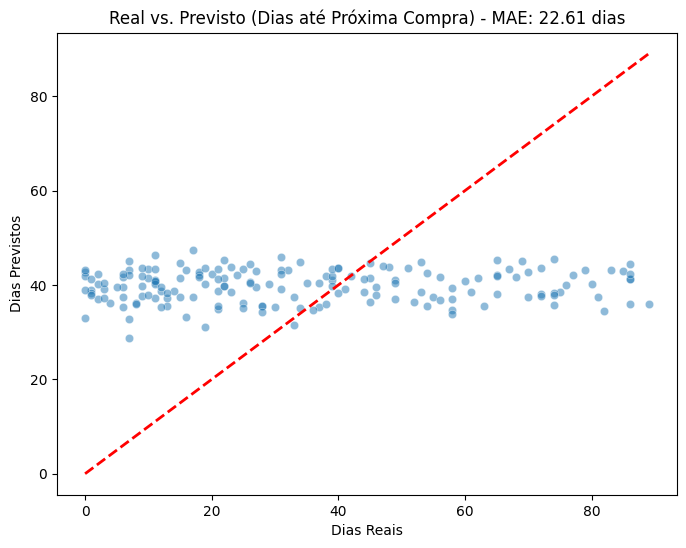

In [6]:
# Bloco 6: Avaliação do Modelo Otimizado (Regressão)

print("\n--- Avaliação do Modelo OTIMIZADO (Regressão) no conjunto de Teste ---")

y_pred_reg = best_model_reg.predict(X_test)

# Calcular Métricas de Regressão
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
mae = mean_absolute_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f"RMSE (Root Mean Squared Error): {rmse:.2f} dias")
print(f"MAE (Mean Absolute Error): {mae:.2f} dias")
print(f"R² Score: {r2:.4f}")

# Visualização Rápida: Previsto vs. Real
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_reg, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2) # Linha de referência perfeita
plt.title(f'Real vs. Previsto (Dias até Próxima Compra) - MAE: {mae:.2f} dias')
plt.xlabel('Dias Reais')
plt.ylabel('Dias Previstos')
plt.show()

# Bloco 7: Treino FINAL e Atualização do customers.parquet


In [7]:
# Bloco 7: Treino FINAL e Atualização do customers.parquet
# Agora treinamos o melhor regressor nos dados completos (X_reg, y_reg)
# e usamos ele para PREVER em TODA a base de clientes (usando a 'Feature Store de Produção' do 04_v2)

print("--- Iniciando etapa final: Treinando regressor final e atualizando customers.parquet ---")

# 1. Treinar o modelo FINAL com os melhores parâmetros em TODOS os dados de regressão (X_reg, y_reg)
print("Treinando modelo FINAL de Regressão com 100% dos dados de clientes recorrentes...")
model_FINAL_reg = random_search_reg.best_estimator_
model_FINAL_reg.fit(X_reg, y_reg)
print("Modelo de Regressão final treinado!")

# 2. Preparar as features de PRODUÇÃO (Idêntico ao Bloco 11 do 04_v2)
# Precisamos das features atuais de TODOS os clientes para prever o futuro deles.
print("Recriando features agregadas para a base de clientes COMPLETA (Produção)...")
df_sales['viaja_sozinho'] = (df_sales['total_tickets_quantity_success'] == 1).astype(int)
df_sales['compra_fds'] = (df_sales['data_venda'].dt.dayofweek >= 5).astype(int)
df_sales['taxa_ida_e_volta'] = (df_sales['place_origin_return'] != '0').astype(int)
snapshot_date_final = df_sales['data_venda'].max() + pd.Timedelta(days=1)
agg_final_base = {
    'data_venda': ['min', 'max'],
    'id_cliente': 'count',
    'valor_venda': 'sum',
    'produto': 'nunique',
    'fk_departure_ota_bus_company': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}
agg_final_comportamento = {'viaja_sozinho': 'mean', 'compra_fds': 'mean', 'taxa_ida_e_volta': 'mean'}
df_features_finais = df_sales.groupby('id_cliente').agg({**agg_final_base, **agg_final_comportamento})
df_features_finais.columns = [
    'Data_Primeira_Compra', 'Data_Ultima_Compra', 'Frequencia_calc', 'ValorMonetario_calc',
    'Rotas_Distintas', 'Viacao_Favorita_Hash', 'pct_viagens_sozinho', 'pct_compras_fds', 'taxa_ida_e_volta'
]
# Usando o RFM completo (notebook 03) para as features principais
df_features_finais = df_features_finais.merge(df_rfm_completo[['Recencia', 'ValorMonetario', 'Frequencia']], left_index=True, right_index=True)
df_features_finais['Ticket_Medio'] = df_features_finais['ValorMonetario'] / df_features_finais['Frequencia']
df_features_finais['Tenure'] = (snapshot_date_final - df_features_finais['Data_Primeira_Compra']).dt.days
df_features_finais['Viacao_Favorita_ID'] = le.transform(df_features_finais['Viacao_Favorita_Hash'])
df_features_finais.fillna(0, inplace=True)
X_para_prever_final = df_features_finais[FEATURES] # Este é o nosso X de produção

# 3. Gerar Predições FINAIS de Regressão para TODOS os clientes
print("Gerando previsões de dias para todos os clientes...")
predicoes_dias_final = model_FINAL_reg.predict(X_para_prever_final)

# 4. Arredondar e formatar as previsões
predicoes_dias_formatado = np.round(predicoes_dias_final, 0).astype(int)

# 5. Criar o DataFrame de resultados
df_novas_previsoes_dias = pd.DataFrame({
    'id_cliente': X_para_prever_final.index,
    'data_prox_viagem_calc': predicoes_dias_formatado
})
# Converter para string para exibir no app (ex: "45 Dias")
df_novas_previsoes_dias['data_prox_viagem_calc'] = df_novas_previsoes_dias['data_prox_viagem_calc'].astype(str) + " Dias"


# 6. Atualizar o arquivo customers.parquet
# (Carregamos df_customers no Bloco 2)
df_customers_atualizado = df_customers.drop(columns=['data_prox_viagem'], errors='ignore')
df_customers_atualizado = df_customers_atualizado.merge(df_novas_previsoes_dias, on='id_cliente', how='left')
df_customers_atualizado = df_customers_atualizado.rename(columns={'data_prox_viagem_calc': 'data_prox_viagem'})

# Garantir que clientes sem previsão de regressão (ex: churned, não estavam no dataset de treino) tenham um placeholder
df_customers_atualizado['data_prox_viagem'].fillna("N/A (Churn)", inplace=True)

# 7. Salvar
df_customers_atualizado.to_parquet(caminho_customers, index=False)

print(f"\nSUCESSO! Arquivo '{caminho_customers}' foi atualizado com as previsões de regressão.")
display(df_customers_atualizado[['nome_cliente', 'segmento', 'prob_compra_30d', 'data_prox_viagem']].head())


--- Iniciando etapa final: Treinando regressor final e atualizando customers.parquet ---
Treinando modelo FINAL de Regressão com 100% dos dados de clientes recorrentes...
Modelo de Regressão final treinado!
Recriando features agregadas para a base de clientes COMPLETA (Produção)...
Gerando previsões de dias para todos os clientes...

SUCESSO! Arquivo '../data/redis/customers.parquet' foi atualizado com as previsões de regressão.


,nome_cliente,segmento,prob_compra_30d,data_prox_viagem
0,Matheus Porto,Perdidos,0.53,39 Dias
1,Diego da Cruz,Fiéis,0.13,41 Dias
2,Luan Gonçalves,Fiéis,0.19,43 Dias
3,Eduardo Gomes,Fiéis,0.10,38 Dias
4,Sophie Garcia,Perdidos,0.26,42 Dias
